In [1]:
%matplotlib inline
import mne
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_function import *

# print version
print(mne.__version__)
# set working directory
os.chdir(os.getcwd())

1.6.1


In [ ]:
for subjidx in range(6):
    for taskidx in range(3):
        # Preprocess the raw data for the given subject and task.
        raw = preprocess_raw_data(subjidx+1,taskidx+1)
        # remove ica components
        ica = mne.preprocessing.ICA(n_components=None, random_state=124,max_iter = 'auto')
        ica.fit(raw)
        #ica.exclude = [0,1] s1t1,2, s2t1,2
        #ica.exclude = [0,1,2]    s1t1,3
        #ica.exclude = [0,7] s3t1
        #ica.exclude = [0,5] s3t2
        #ica.exclude = [0,1,2] s4t1,2,3
        #ica.exclude = [0,1] s5t1 
        #ica.exclude = [0,1,4] s5t2
        #ica.exclude = [0,3] s5t3
        #ica.exclude = [0,1,2] s6t1,2,3
        #ica.exclude = [0,1]

        eog_indices, eog_scores = ica.find_bads_eog(raw)                               
        ica.exclude = eog_indices
        ica.apply(raw)
        raw.save(f'../2_Data/Preprocessed/sub-{subjidx+1:02d}_task-GTDT_run-{taskidx+1:02d}_eeg.fif', overwrite=True)

In [36]:
file_path = f'../2_Data/Preprocessed/sub-01_task-GTDT_run-01_eeg.fif'
raw = mne.io.read_raw_fif(file_path, preload=True)

Opening raw data file ../2_Data/Preprocessed/sub-01_task-GTDT_run-01_eeg.fif...
    Range : 0 ... 747417 =      0.000 ...  1459.799 secs
Ready.
Reading 0 ... 747417  =      0.000 ...  1459.799 secs...


In [53]:
# Find and annotate events in the EEG data.
events, event_id = mne.events_from_annotations(raw)
# cause the marker of square appear twice, we only need the first marker
for i in range(len(events[:,2])):
    if events[:,2][i]==9 and events[:,2][i+1]==9:
        events[:,2][i] = 99
# cause the marker of response appear twice in some trials, we only need the first marker
for i in range(len(events[:,2])):
    if events[:,2][i]==2 and events[:,2][i+1]==2:
        events[:,2][i+1] = 22
# set the marker
stim_ids = {'Stimulus/S  1':1} # the marker of circle onset
resp_ids = {'Stimulus/S  2':2} # the marker of response
sq_ids = {'Stimulus/S  9':9} # the marker of square onset

# circle onset-locked epochs
tmin, tmax = -0.75, 2 # the time segment for epochs 
baseline = (-0.5, 0) # the time window for baseline correction

epochs_stim = mne.Epochs(raw, events, stim_ids, tmin=tmin,picks=['eeg','eog'], tmax=tmax, reject=dict(eeg=100e-6,eog=200e-6)) 

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113']
Not setting metadata
75 matching events found
Setting baseline interval to [-0.75, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


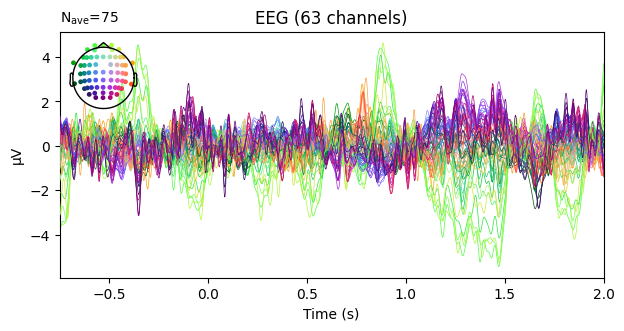

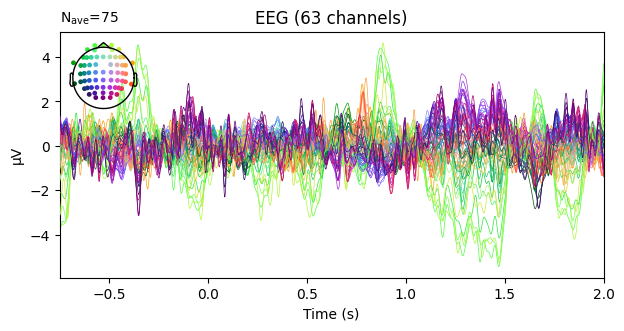

In [16]:
electrodes = ['CPz','CP1','CP2']
epochs_stim.average().plot()

In [2]:
drops = []
event_num = []
for subjidx in range(6):
    for taskidx in range(3):
        file_path = f'../2_Data/Preprocessed/sub-{subjidx+1:02d}_task-GTDT_run-{taskidx+1:02d}_eeg.fif'
        raw = mne.io.read_raw_fif(file_path, preload=True)
        events, event_id = mne.events_from_annotations(raw)
        # cause the marker of square appear twice, we only need the first marker
        for i in range(len(events[:,2])):
            if events[:,2][i]==9 and events[:,2][i+1]==9:
                events[:,2][i] = 99
        # cause the marker of response appear twice in some trials, we only need the first marker
        for i in range(len(events[:,2])):
            if events[:,2][i]==2 and events[:,2][i+1]==2:
                events[:,2][i+1] = 22
        # set the marker
        stim_ids = {'Stimulus/S  1':1} # the marker of circle onset
        resp_ids = {'Stimulus/S  2':2} # the marker of response
        sq_ids = {'Stimulus/S  9':9} # the marker of square onset

        # circle onset-locked epochs
        tmin, tmax = -0.75, 2 # the time segment for epochs 
        baseline = (-0.5, 0) # the time window for baseline correction
        epochs_stim = mne.Epochs(raw, events, stim_ids, tmin=tmin,picks=['eeg','eog'], tmax=tmax, reject=dict(eeg=100e-6,eog=200e-6),baseline=baseline) 
        event_num.append(len(epochs_stim.events))
        epochs_stim.get_data()
        rejected_epochs_indices = [i for i, log in enumerate(epochs_stim.drop_log) if log and 'IGNORED' not in log]
        drops.append(rejected_epochs_indices)

Opening raw data file ../2_Data/Preprocessed/sub-01_task-GTDT_run-01_eeg.fif...
    Range : 0 ... 747417 =      0.000 ...  1459.799 secs
Ready.
Reading 0 ... 747417  =      0.000 ...  1459.799 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113']
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 75 events and 1409 original time points ...
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Reject

In [3]:
# proportion of drop trials
np.array([len(i) for i in drops])/np.array(event_num)

array([0.16      , 0.1986755 , 0.25      , 0.        , 0.01324503,
       0.00806452, 0.1       , 0.05960265, 0.79032258, 0.16      ,
       0.17218543, 0.10483871, 0.14      , 0.41059603, 0.28225806,
       0.3       , 0.43708609, 0.23387097])

In [ ]:
# Initialize an empty DataFrame to store the final data
df = pd.DataFrame()
# Loop through each subject
cpp_erp = np.empty([6,75,1024])
lhb_erp = np.empty([6,75,1024])

for subjidx in range(6):
    # Adjust the subject index to start from 1 instead of 0
    subjidx = subjidx+1
    # Define the file path for the EEG data and load the EEG data using MNE
    file_path = f'../2_Data/Preprocessed/sub-{subjidx:02d}_task-GTDT_run-01_eeg.fif'
    raw = mne.io.read_raw_fif(file_path, preload=True)
    # Define the folder and file name for the behavioral data   
    folder = 'PreData'
    task = os.path.join('sub-'+str(subjidx).zfill(2)+'_task-GTDT_run-01_beh.csv')
    filename_beh = os.path.join(folder,'sub-'+str(subjidx).zfill(2),task)
    # Initialize a temporary DataFrame to store the subject's data.
    temp_data = pd.DataFrame(columns=[
        'subj_index',
        'subj_idx',
        'rt', 
        'amp_cpp',    
        'amp_cum_ssvep', 
    ])
    # Find and annotate events in the EEG data.
    events, event_id = mne.events_from_annotations(raw)
    # cause the marker of square appear twice, we only need the first marker
    for i in range(len(events[:,2])):
        if events[:,2][i]==9 and events[:,2][i+1]==9:
            events[:,2][i] = 99
    # cause the marker of response appear twice in some trials, we only need the first marker
    for i in range(len(events[:,2])):
        if events[:,2][i]==2 and events[:,2][i+1]==2:
            events[:,2][i+1] = 22
    # set the marker
    stim_ids = {'Stimulus/S  1':1} # the marker of circle onset
    resp_ids = {'Stimulus/S  2':2} # the marker of response
    sq_ids = {'Stimulus/S  9':9} # the marker of square onset

    # circle onset-locked epochs
    tmin, tmax = -0.75, 2 # the time segment for epochs 
    baseline = (-0.5, 0) # the time window for baseline correction
    epochs_stim = mne.Epochs(raw, events, stim_ids, tmin=tmin,picks='eeg', tmax=tmax, baseline=baseline) 

    # prepare the single trial data, we need to choose the roi and average them
    electrodes = ['CPz','CP1','CP2'] # the electrodes of CPP
    epochs_stim.load_data() # load epoch
    epochs_stim_cpp = pd.DataFrame(epochs_stim.copy().pick_channels(electrodes).get_data().mean(axis=1)) # select roi and average them
    dfs_stim = pd.read_csv(filename_beh,sep=',',index_col=0) # read the behavioral data
    epochs_stim_cpp['rt'] = dfs_stim.loc[dfs_stim['RtTimes']==1,'Rt'].reset_index(drop=True).replace(np.nan,0) # get the rt of first response and replace NA to 0

    epochs_stim_cpp = epochs_stim_cpp.sort_values(by=['rt'],ascending=True) # sort epochs by value of rt
    # plot the dynamics of the stim-locked CPP
    cpp = epochs_stim.average().to_data_frame() # average the epochs
    cpp['value'] = np.mean(cpp[electrodes],axis=1) # average the electrodes

    # resp-locked epochs
    tmin, tmax = -1.2, 0.4 # the time segment for epochs 
    epochs_resp = mne.Epochs(raw, events, resp_ids, tmin=tmin,picks='eeg', tmax=tmax)

    # Preparing the single trial data
    # Selecting the electrodes of CPP
    electrodes = ['CPz','CP1','CP2'] 
    # Loading the epoch data
    epochs_resp.load_data()
    # Selecting the region of interest (ROI) and averaging the data
    epochs_resp_cpp = pd.DataFrame(epochs_resp.copy().pick_channels(electrodes).get_data().mean(axis=1))
    # Reading the behavioral data
    dfs_stim = pd.read_csv(filename_beh,sep=',',index_col=0)
    # Getting the response time (rt) of the first response and replacing NA with 0
    epochs_resp_cpp['rt'] = dfs_stim.loc[(dfs_stim['RtTimes']==1)&(dfs_stim['Rt'].notna()),'Rt'].reset_index(drop=True).replace(np.nan,0)
    # Getting the squared response time (rtsquare) of the first response and replacing NA with 0
    epochs_resp_cpp['rtsquare'] = dfs_stim.loc[(dfs_stim['RtTimes']==1)&(dfs_stim['RtSquare'].notna()),'RtSquare'].reset_index(drop=True).replace(np.nan,0)
    # Sorting epochs by value of rt (response time)
    epochs_resp_cpp = epochs_resp_cpp.sort_values(by=['rt'],ascending=True)

    # Calculate the amplitude of the CPP component for each trial within a specific time window around the reaction time.
    cppdata = []
    for i in range(len(temp_data)):
        # Calculate the mean amplitude within the time window for each trial and add it to the 'cppdata' list.
        cppdata.append(np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75 - 0.05) * 512):int((0.75 + 0.05 + temp_data['rt'][i]) * 512)].mean(axis=1)[i])
    #
    if np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 75:
        cpp_erp[subjidx - 1][:np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0]] = np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)]
        cpp_erp[subjidx - 1][np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0]:] = np.nan
    
    else:
        # Store the averaged event-related potential (ERP) data for CPP in the 'cpp_erp' array.
        cpp_erp[subjidx - 1] = np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)]





    # Setting the time window for the CPP amplitude
    tw = [-0.05,0.05]
    # Calculating the mean amplitude of the CPP within the defined time window 
    temp_data['amp_cpp']=epochs_resp_cpp.loc[:,int((1.2+tw[0])*512):int((1.2+tw[1])*512)].mean(axis=1)
    # Sorting the data by index
    temp_data = temp_data.sort_index()
    # Adding the response time to the data
    temp_data['rt']=epochs_resp_cpp['rt']
    # Preparing for the ssvep analysis
    # Selecting the electrodes
    electrodes = ['Oz', 'O1', 'O2', 'POz', 'PO3', 'PO4']
    # Creating a copy of the raw data and selecting the channels
    sraw = raw.copy()
    sraw = sraw.pick_channels(electrodes)
    # Defining the ssvep frequencies
    ssvep_freq = np.array([21.25,22])
    # Defining the time segment for epochs 
    tmin, tmax = -0.75, 2 
    # Creating epochs
    sepochs = mne.Epochs(sraw, events , stim_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Performing a morlet wavelet transform on the epochs
    tfr = mne.time_frequency.tfr_morlet(sepochs, freqs=ssvep_freq,picks='all',
                                n_cycles=ssvep_freq/2, return_itc=False,average=False)
    # Defining the time segment for epochs 
    tmin, tmax = -1.2, 0.4  
    # Creating epochs for responses
    sepochs_resp = mne.Epochs(sraw, events , resp_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Performing a morlet wavelet transform on the response epochs
    tfr_resp = mne.time_frequency.tfr_morlet(sepochs_resp, freqs=ssvep_freq,picks='all',
                                n_cycles=ssvep_freq/2, return_itc=False,average=False)
    # Calculating the cumulative sum of the mean power of the ssvep response
    ssvepdata = np.cumsum(np.mean(np.mean(tfr_resp.data,axis=1),axis=1)[:,0:int(1.2*512)],axis=1)[:,-1]
    # Adding the calculated ssvep amplitude to the data
    temp_data['amp_cum_ssvep'] = ssvepdata
    # Adding the subject index to the data
    temp_data['subj_idx'] = subjidx 
    # Adding a column for the subject index
    temp_data['subj_index'] = np.arange(len(temp_data)) 
    # Concatenating the data with the existing dataframe
    df=pd.concat([df,temp_data])

   # Prepare data for LHB analysis.
    # Define the time window (in seconds) for extracting epochs.
    tmin, tmax = -0.75, 2
    # Define the electrodes to be used.
    electrodes =['C3', 'C1', 'C5']
    # Creating a copy of the raw data and selecting the channels
    sraw = raw.copy()
    sraw = sraw.pick_channels(electrodes)
    # Defining the ssvep frequencies
    ssvep_freq = np.array([21.25,22])
    # Defining the time segment for epochs 
    tmin, tmax = -0.75, 2 
    # Define the frequencies of interest for the time-frequency representation.
    freqs = np.linspace(22, 30, 10)
    # Creating epochs
    sepochs = mne.Epochs(sraw, events , stim_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Perform time-frequency decomposition on the concatenated epochs using Morlet wavelets.
    tfr = mne.time_frequency.tfr_morlet(sepochs, freqs=freqs,picks='all',
                                    n_cycles=8, return_itc=False,average=False)
    tfr_resp = mne.time_frequency.tfr_morlet(sepochs_resp, freqs=ssvep_freq,picks='all',
                                    n_cycles=8, return_itc=False,average=False)
    # Initialize an empty list to store LHB data.
    lhbdata = []
    # Loop through each element in temp_data to calculate the mean power based on reaction time (rt).
    for i in range(len(temp_data)):
        lhbdata.append(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int((0.75-0.05)*512):int((0.75+0.05+temp_data['rt'][i])*512)].mean())
    if np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 75:
        lhb_erp[subjidx - 1][:np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)].shape[0]] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]
        lhb_erp[subjidx - 1][np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)].shape[0]:] = np.nan
    
    else:
        # Calculate the average power across channels and epochs for a fixed interval after 0.75 seconds and assign it to lhb_erp.
        lhb_erp[subjidx-1] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]




    

df.to_csv('df_task1.csv',index=False)
# Save the ERP data and the combined DataFrame to files for later use.
np.save('df_task1_lhb',lhb_erp)
np.save('df_task1_cpp',cpp_erp)




In [ ]:
# Initialize an empty DataFrame to store the combined data from all participants.
df = pd.DataFrame()
# Initialize empty arrays to store ERP data for each condition across all participants.
cpp_erp = np.empty([6,150,1024])
lhb_erp = np.empty([6,150,1024])
ssvep_erp = np.empty([6,150,1024])
cpp_erp_resp = []
lhb_erp_resp = []
ssvep_erp_resp = []
# Loop over the participant indices.
for subjidx in range(6):
    # Increment subject index to start from 1.
    subjidx = subjidx+1
    # Load EEG data for runs 2 and 3.
    file_path = f'../2_Data/Preprocessed/sub-{subjidx:02d}_task-GTDT_run-02_eeg.fif'
    raw2 = mne.io.read_raw_fif(file_path, preload=True)

    file_path = f'../2_Data/Preprocessed/sub-{subjidx:02d}_task-GTDT_run-03_eeg.fif'
    raw3 = mne.io.read_raw_fif(file_path, preload=True)

    taskidx = 2
    folder = 'PreData'
    task = os.path.join('sub-'+os.path.join(str(subjidx).zfill(2))+'_task-GTDT'+'_run-'+str(taskidx).zfill(2)+'_beh.csv')
    filename_beh2 = os.path.join(folder,'sub-'+str(subjidx).zfill(2),task)

    # Load behavioral data for runs 2 and 3.
    taskidx = 3
    folder = 'PreData'
    task = os.path.join('sub-'+os.path.join(str(subjidx).zfill(2))+'_task-GTDT'+'_run-'+str(taskidx).zfill(2)+'_beh.csv')
    filename_beh3 = os.path.join(folder,'sub-'+str(subjidx).zfill(2),task)

    # Process events for runs 2 and 3, marking segments that should be treated as a single condition.
    events2, event_id = mne.events_from_annotations(raw2)
    arr = events2[:,2]
    six_indices = np.where(arr == 6)[0]
    segment_start = []
    segment_end = []

    for i in range(len(six_indices) - 1):
        start = six_indices[i] 
        end = six_indices[i + 1]
        
        # Check if segment contains only 1s
        if np.all(arr[start+1:end] == 1) and len(arr[start+1:end])!=0:
            segment_start.append(start+1)
            segment_end.append(end)
    for start, end in zip(segment_start, segment_end):
        events2[:,2][start:end] = 11


    events3, event_id = mne.events_from_annotations(raw3)
    arr = events3[:,2]
    six_indices = np.where(arr == 6)[0]
    segment_start = []
    segment_end = []

    for i in range(len(six_indices) - 1):
        start = six_indices[i] 
        end = six_indices[i + 1]
        
        # Check if segment contains only 1s
        if np.all(arr[start+1:end] == 1) and len(arr[start+1:end])!=0:
            segment_start.append(start+1)
            segment_end.append(end)
    for start, end in zip(segment_start, segment_end):
        events3[:,2][start:end] = 11

    # Define the identifiers for different types of events.
    stim_ids = {'Stimulus/S  1':1}
    resp_ids = {'Stimulus/S  2':2}
    count_ids = {'Stimulus/S  11':11}
    # Create epochs for stimulus events for runs 2 and 3 and concatenate them.
    tmin, tmax = -0.75, 2
    baseline = (-0.5, 0)
    epochs_stim2 = mne.Epochs(raw2, events2, stim_ids, tmin=tmin,picks='eeg', tmax=tmax, baseline=baseline)
    epochs_stim3 = mne.Epochs(raw3, events3, stim_ids, tmin=tmin,picks='eeg', tmax=tmax, baseline=baseline)
    epochs_stim = mne.concatenate_epochs([epochs_stim2, epochs_stim3])
    tmin, tmax = -1.5, 0.5
    epochs_resp2 = mne.Epochs(raw2, events2, resp_ids, tmin=tmin,picks='eeg', tmax=tmax)
    epochs_resp3 = mne.Epochs(raw3, events3, resp_ids, tmin=tmin,picks='eeg', tmax=tmax)
    epochs_resp = mne.concatenate_epochs([epochs_resp2, epochs_resp3])


    # Prepare data for CPP analysis.
    # Select electrodes associated with the Central Parietal Positivity (CPP) component.
    electrodes = ['CPz', 'CP1', 'CP2']
    # Load the epoch data into memory for further processing.
    epochs_stim.load_data()
    # Create a DataFrame from the epochs by averaging the signals across the selected electrodes.
    # This step isolates the CPP component for each trial.
    epochs_stim_cpp = pd.DataFrame(epochs_stim.copy().pick_channels(electrodes).get_data().mean(axis=1))

    # Load the epoch data into memory for further processing.
    epochs_resp.load_data()
    # Create a DataFrame from the epochs by averaging the signals across the selected electrodes.
    # This step isolates the CPP component for each trial.
    cpp_erp_resp.append(np.mean(epochs_resp.copy().pick_channels(electrodes).get_data(), axis=1)) 
    # Load the behavioral data from the CSV file.
    dfs_stim = pd.read_csv(filename_beh2, sep=',', index_col=0)
    # Extract reaction times (RT) from the behavioral data, corresponding to the first response times.
    # Replace missing values (NaN) with 0.
    epochs_stim_cpp['rt'] = dfs_stim.loc[dfs_stim['RtTimes'] == 1, 'Rt'].reset_index(drop=True).replace(np.nan, 0)
    # Sort the trials by reaction time.
    epochs_stim_cpp = epochs_stim_cpp.sort_values(by=['rt'], ascending=True)
    # Initialize a temporary DataFrame to store additional data for each trial.
    temp_data = pd.DataFrame(columns=[
        'subj_index',        # Index of the subject within the study.
        'subj_idx',          # Identifier of the subject.
        'rt',                # Reaction time.
        'amp_cpp',           # Amplitude of the CPP component.
        'amp_lhb',           # Amplitude of the left hemisphere beta activity (placeholder, to be calculated later).
        'amp_cum_ssvep',     # Cumulative amplitude of the SSVEP (placeholder, to be calculated later).
    ])
    # Set the time window for calculating the CPP amplitude.
    tmin, tmax = -0.75, 2
    tw = [-0.05, 0.05]
    # Sort the temporary DataFrame by index.
    temp_data = temp_data.sort_index()
    # Add reaction times to the temporary DataFrame.
    temp_data['rt'] = epochs_stim_cpp['rt']
    # Sort the temporary DataFrame again after adding the reaction times.
    temp_data = temp_data.sort_index()
    # Calculate the amplitude of the CPP component for each trial within a specific time window around the reaction time.
    cppdata = []
    for i in range(len(temp_data)):
        # Calculate the mean amplitude within the time window for each trial and add it to the 'cppdata' list.
        cppdata.append(np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75 - 0.05) * 512):int((0.75 + 0.05 + temp_data['rt'][i]) * 512)].mean(axis=1)[i])
    # Store the averaged event-related potential (ERP) data for CPP in the 'cpp_erp' array.
    cpp_erp[subjidx - 1] = np.mean(epochs_stim.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)]

    # Prepare data for SSVEP analysis.
    electrodes = ['Oz', 'O1', 'O2', 'POz', 'PO3', 'PO4']
    # Copy the raw2 object to sraw2 and select only the channels specified in 'electrodes'.
    sraw2 = raw2.copy()
    sraw2 = sraw2.pick_channels(electrodes)
    # Copy the raw3 object to sraw3 and select only the channels specified in 'electrodes'.
    sraw3 = raw3.copy()
    sraw3 = sraw3.pick_channels(electrodes)
    # Commented out line: This line would get the data from sraw if it was uncommented.
    #sraw = sraw.get_data()
    # Define the frequencies of interest for the SSVEP analysis.
    ssvep_freq = [21.25,22]
    # Create epochs from the sraw2 data based on events, time window, and baseline correction.
    sepochs2 = mne.Epochs(sraw2, events2 , stim_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Create epochs from the sraw3 data based on events, time window, and baseline correction.
    sepochs3 = mne.Epochs(sraw3, events3 , stim_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Concatenate the epochs from sraw2 and sraw3 into a single Epochs object.
    sepochs = mne.concatenate_epochs([sepochs2, sepochs3])
    # Create epochs from the sraw2 data based on events, time window, and baseline correction.
    sepochs2_resp = mne.Epochs(sraw2, events2 , resp_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs3_resp = mne.Epochs(sraw3, events3 , resp_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs_resp = mne.concatenate_epochs([sepochs2_resp, sepochs3_resp])

    # Perform time-frequency decomposition using Morlet wavelets on the concatenated epochs.
    tfr = mne.time_frequency.tfr_morlet(sepochs, freqs=ssvep_freq,picks='all',
                                    n_cycles=8, return_itc=False,average=False)
    tfr_resp = mne.time_frequency.tfr_morlet(sepochs_resp, freqs=ssvep_freq,picks='all',
                                    n_cycles=8, return_itc=False,average=False)
    # Initialize an empty list to store cumulative data.
    ssvepcumdata = []
    # Loop through each element in temp_data to calculate cumulative data based on reaction time (rt).
    for i in range(len(temp_data)):
        # Calculate the cumulative sum of the average power across channels and epochs after 0.75 seconds.
        # If the resulting shape is 0, assign NaN, otherwise assign the cumulative sum of the last element.
        if np.cumsum(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+temp_data['rt'][i])*512)],axis=1).shape[1]==0:
            value = np.nan
        else:
            value = np.cumsum(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+temp_data['rt'][i])*512)],axis=1)[i,-1]
        # Append the calculated value to the ssvepcumdata list.
        ssvepcumdata.append(value)
    # Calculate the average power across channels and epochs for a fixed interval after 0.75 seconds and assign it to ssvep_erp.
    ssvep_erp[subjidx-1] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]
    ssvep_erp_resp.append(np.mean(np.mean(tfr_resp.data,axis=1),axis=1))
    # Initialize an empty list to store SSVEP data.
    ssvepdata = []
    # Loop through each element in temp_data to calculate the mean power based on reaction time (rt).
    for i in range(len(temp_data)):
        # Calculate and append the mean of the average power across channels and epochs for each reaction time.
        ssvepdata.append(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int((0.75-0.05)*512):int((0.75+0.05+temp_data['rt'][i])*512)].mean())

    # Prepare data for LHB analysis.
    # Define the time window (in seconds) for extracting epochs.
    tmin, tmax = -0.75, 2
    # Define the electrodes to be used.
    electrodes =['C3', 'C1', 'C5']
    # Copy data from raw2 to sraw2 and select channels specified in 'electrodes'.
    sraw2 = raw2.copy()
    sraw2 = sraw2.pick_channels(electrodes)
    # Copy data from raw3 to sraw3 and select channels specified in 'electrodes'.
    sraw3 = raw3.copy()
    sraw3 = sraw3.pick_channels(electrodes)
    # Define the frequencies of interest for the time-frequency representation.
    freqs = np.linspace(22, 30, 10)
    # Create epochs from the sraw2 data based on events, time window, and baseline correction.
    sepochs2 = mne.Epochs(sraw2, events2 , stim_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Create epochs from the sraw3 data based on events, time window, and baseline correction.
    sepochs3 = mne.Epochs(sraw3, events3 , stim_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    # Concatenate the epochs from sraw2 and sraw3 into a single Epochs object.
    sepochs = mne.concatenate_epochs([sepochs2, sepochs3])
    sepochs2_resp = mne.Epochs(sraw2, events2 , resp_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs3_resp = mne.Epochs(sraw3, events3 , resp_ids, tmin=tmin,picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs_resp = mne.concatenate_epochs([sepochs2_resp, sepochs3_resp])
    # Perform time-frequency decomposition on the concatenated epochs using Morlet wavelets.
    tfr = mne.time_frequency.tfr_morlet(sepochs, freqs=freqs,picks='all',
                                    n_cycles=8, return_itc=False,average=False)
    tfr_resp = mne.time_frequency.tfr_morlet(sepochs_resp, freqs=ssvep_freq,picks='all',
                                    n_cycles=8, return_itc=False,average=False)
    # Initialize an empty list to store LHB data.
    lhbdata = []
    # Loop through each element in temp_data to calculate the mean power based on reaction time (rt).
    for i in range(len(temp_data)):
        lhbdata.append(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int((0.75-0.05)*512):int((0.75+0.05+temp_data['rt'][i])*512)].mean())
    # Calculate the average power across channels and epochs for a fixed interval after 0.75 seconds and assign it to lhb_erp.
    lhb_erp[subjidx-1] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]
    lhb_erp_resp.append(np.mean(np.mean(tfr_resp.data,axis=1),axis=1))
    # Add SSVEP, LHB, and CPP data to the temp_data DataFrame.
    temp_data['amp_ssvep'] = ssvepdata
    temp_data['amp_cum_ssvep'] = ssvepcumdata
    temp_data['pl_ssvep'] =np.argmax(ssvep_erp[subjidx-1],axis=1)/521
    temp_data['pl_lhb'] =np.argmax(lhb_erp[subjidx-1],axis=1)/512
    temp_data['pl_cpp'] =np.argmax(cpp_erp[subjidx-1],axis=1)/512
    temp_data['amp_lhb'] = lhbdata
    temp_data['amp_cpp'] = cppdata
    # Add subject index to the temp_data DataFrame.
    temp_data['subj_idx'] = subjidx 
    temp_data['subj_index'] = np.arange(len(temp_data)) 
    # Concatenate temp_data with the existing DataFrame df.
    df=pd.concat([df,temp_data]) 
# Save the ERP data and the combined DataFrame to files for later use.
np.save('df_task2_lhb',lhb_erp)
np.save('df_task2_cpp',cpp_erp)
np.save('df_task2_ssvep',ssvep_erp)
np.save('df_task2_lhb_resp',lhb_erp_resp)
np.save('df_task2_cpp_resp',cpp_erp_resp)
np.save('df_task2_ssvep_resp',ssvep_erp_resp)
df.to_csv('df_task2.csv',index=False)

In [12]:
df = pd.DataFrame()
# Initialize empty arrays to store ERP data for each condition across all participants.
cpp_erp = np.empty([6,150,1024])
lhb_erp = np.empty([6,150,1024])
ssvep_erp = np.empty([6,150,1024])

for subjidx in range(6):
    # Increment subject index to start from 1.
    subjidx = subjidx+1
    # Load EEG data for runs 2 and 3.
    file_path = f'../2_Data/Preprocessed/sub-{subjidx:02d}_task-GTDT_run-02_eeg.fif'
    raw2 = mne.io.read_raw_fif(file_path, preload=True)

    file_path = f'../2_Data/Preprocessed/sub-{subjidx:02d}_task-GTDT_run-03_eeg.fif'
    raw3 = mne.io.read_raw_fif(file_path, preload=True)

    taskidx = 2
    folder = 'PreData'
    task = os.path.join('sub-'+os.path.join(str(subjidx).zfill(2))+'_task-GTDT'+'_run-'+str(taskidx).zfill(2)+'_beh.csv')
    filename_beh2 = os.path.join(folder,'sub-'+str(subjidx).zfill(2),task)

    # Load behavioral data for runs 2 and 3.
    taskidx = 3
    folder = 'PreData'
    task = os.path.join('sub-'+os.path.join(str(subjidx).zfill(2))+'_task-GTDT'+'_run-'+str(taskidx).zfill(2)+'_beh.csv')
    filename_beh3 = os.path.join(folder,'sub-'+str(subjidx).zfill(2),task)
    
    # Extract events and their IDs from annotations in the raw2 EEG data.
    events2, event_id = mne.events_from_annotations(raw2)
    # Get the event codes from the events array.
    arr = events2[:,2]
    # Find indices where the event code is 6.
    six_indices = np.where(arr == 6)[0]
    # Initialize lists to store the start and end indices of segments.
    segment_start = []
    segment_end = []

    # Loop through the indices to find segments that contain only the event code 1 between two event code 6.
    for i in range(len(six_indices) - 1):
        start = six_indices[i] 
        end = six_indices[i + 1]
        
        # Check if the segment between two indices of event code 6 contains only event code 1.
        if np.all(arr[start+1:end] == 1) and len(arr[start+1:end])!=0:
            segment_start.append(start+1)
            segment_end.append(end)
    # Mark these segments with the event code 11.
    for start, end in zip(segment_start, segment_end):
        events2[:,2][start:end] = 11

    # Repeat the process for the raw3 EEG data.
    events3, event_id = mne.events_from_annotations(raw3)
    arr = events3[:,2]
    six_indices = np.where(arr == 6)[0]
    segment_start = []
    segment_end = []

    for i in range(len(six_indices) - 1):
        start = six_indices[i] 
        end = six_indices[i + 1]
        
        if np.all(arr[start+1:end] == 1) and len(arr[start+1:end])!=0:
            segment_start.append(start+1)
            segment_end.append(end)
    for start, end in zip(segment_start, segment_end):
        events3[:,2][start:end] = 11

    # Define dictionaries for stimulus, response, and count event IDs.
    stim_ids = {'Stimulus/S  1':1}
    resp_ids = {'Stimulus/S  2':2}
    count_ids = {'Stimulus/S  11':11}

    # Set the time window and baseline for epoch extraction.
    tmin, tmax = -0.75, 2
    baseline = (-0.5, 0)
    # Create epochs for the count event (event code 11) from both raw2 and raw3 EEG data.
    epochs_count2 = mne.Epochs(raw2, events2, count_ids, tmin=tmin,picks='eeg', tmax=tmax, baseline=baseline)
    epochs_count3 = mne.Epochs(raw3, events3, count_ids, tmin=tmin,picks='eeg', tmax=tmax, baseline=baseline)
    # Concatenate the epochs from both datasets into a single Epochs object.
    epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])
    # Initialize an empty DataFrame.
    temp_data = pd.DataFrame()
    # Select the electrodes of interest for the CPP ERP component.
    electrodes = ['CPz','CP1','CP2']
    # Load the epochs data into memory.
    epochs_count.load_data()
    # Create a DataFrame with the mean data across the selected electrodes (roi).
    epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
    # Define a time window and calculate the mean CPP amplitude within this window.
    tw = [0,1.6]
    temp_data['amp_cpp'] = epochs_count_cpp.loc[:,int((0.75+tw[0])*512):int((0.75+tw[1])*512)].mean(axis=1)
    # Sort the DataFrame by index.
    temp_data = temp_data.sort_index()

    if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:
        cpp_erp[subjidx - 1][:np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0]] = np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)]
        cpp_erp[subjidx - 1][np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0]:] = np.nan
    
    else:
        # Store the averaged event-related potential (ERP) data for CPP in the 'cpp_erp' array.
        cpp_erp[subjidx - 1] = np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)]



    # Select the electrodes of interest for the SSVEP ERP component.
    electrodes = ['Oz', 'O1', 'O2', 'POz', 'PO3', 'PO4']
    # Copy raw2 data, select channels, and repeat for raw3.
    sraw2 = raw2.copy()
    sraw2 = sraw2.pick_channels(electrodes)
    sraw3 = raw3.copy()
    sraw3 = sraw3.pick_channels(electrodes)
    # Define the SSVEP frequencies of interest.
    ssvep_freq = [21.25,22]
    # Create epochs from sraw2 and sraw3, then concatenate them.
    sepochs2 = mne.Epochs(sraw2, events2 , count_ids, tmin=tmin, picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs3 = mne.Epochs(sraw3, events3 , count_ids, tmin=tmin, picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs = mne.concatenate_epochs([sepochs2, sepochs3])
    # Compute time-frequency representation using Morlet wavelets.
    tfr = mne.time_frequency.tfr_morlet(sepochs, freqs=ssvep_freq, picks='all', n_cycles=8, return_itc=False, average=False)
    # Calculate the cumulative sum of the mean power at the SSVEP frequencies.
    ssvepdata = np.cumsum(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,0:int(1.6*512)],axis=1)[:,-1]
    if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:
        ssvep_erp[subjidx - 1][:np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)].shape[0]] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]
        ssvep_erp[subjidx - 1][np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)].shape[0]:] = np.nan
    
    else:
        # Calculate the average power across channels and epochs for a fixed interval after 0.75 seconds and assign it to lhb_erp.
        ssvep_erp[subjidx-1] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]
    
    # Repeat the process for the LHB ERP component.
    tmin, tmax = -0.75, 2
    electrodes =['C3', 'C1', 'C5']
    sraw2 = raw2.copy()
    sraw2 = sraw2.pick_channels(electrodes)
    sraw3 = raw3.copy()
    sraw3 = sraw3.pick_channels(electrodes)
    freqs = np.linspace(22, 30, 10)
    sepochs2 = mne.Epochs(sraw2, events2 , stim_ids, tmin=tmin, picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs3 = mne.Epochs(sraw3, events3 , stim_ids, tmin=tmin, picks=electrodes, tmax=tmax, baseline=baseline)
    sepochs = mne.concatenate_epochs([sepochs2, sepochs3])
    tfr = mne.time_frequency.tfr_morlet(sepochs, freqs=freqs, picks='all', n_cycles=8, return_itc=False, average=False)
    # Compute the mean power for each trial at the LHB frequencies.
    lhbdata = []
    for i in range(len(temp_data)):
        lhbdata.append(np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int((0)*512):int((1.6)*512)].mean())        
    if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:
        lhb_erp[subjidx - 1][:np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)].shape[0]] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]
        lhb_erp[subjidx - 1][np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)].shape[0]:] = np.nan
    
    else:
        # Calculate the average power across channels and epochs for a fixed interval after 0.75 seconds and assign it to lhb_erp.
        lhb_erp[subjidx-1] = np.mean(np.mean(tfr.data,axis=1),axis=1)[:,int(0.75*512):int((0.75+2)*512)]

    # Add the LHB and SSVEP data to the DataFrame.
    temp_data['amp_lhb'] = lhbdata
    temp_data['amp_cum_ssvep'] = ssvepdata
    # Add subject index to the DataFrame.
    temp_data['subj_idx'] = subjidx 
    temp_data['subj_index'] = np.arange(len(temp_data)) 
    # Concatenate temp_data with the existing DataFrame df.
    df=pd.concat([df,temp_data]) 
df.to_csv('df_task3.csv',index=False)
# Save the ERP data and the combined DataFrame to files for later use.
np.save('df_task3_lhb',lhb_erp)
np.save('df_task3_cpp',cpp_erp)


Opening raw data file ../2_Data/Preprocessed/sub-01_task-GTDT_run-02_eeg.fif...
    Range : 0 ... 1153965 =      0.000 ...  2253.838 secs
Ready.
Reading 0 ... 1153965  =      0.000 ...  2253.838 secs...
Opening raw data file ../2_Data/Preprocessed/sub-01_task-GTDT_run-03_eeg.fif...
    Range : 0 ... 903474 =      0.000 ...  1764.598 secs
Ready.
Reading 0 ... 903474  =      0.000 ...  1764.598 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time p

C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:93: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order wi

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:95: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  cpp_erp[subjidx - 1][np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0]:] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:95: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  cpp_erp[subjidx - 1][np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0]:] = np.nan


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:107: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw2 = sraw2.pick_channels(electrodes)


Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 51 events and 1409 original time points ...
Using data from preloaded Raw for 74 events and 1409 original time points ...
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:109: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw3 = sraw3.pick_channels(electrodes)
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:115: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 1409 original time points ...
Using data from preloaded Raw for 50 events and 1409 original time points ...
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:131: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Opening raw data file ../2_Data/Preprocessed/sub-02_task-GTDT_run-02_eeg.fif...


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:137: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:


    Range : 0 ... 924630 =      0.000 ...  1805.918 secs
Ready.
Reading 0 ... 924630  =      0.000 ...  1805.918 secs...
Opening raw data file ../2_Data/Preprocessed/sub-02_task-GTDT_run-03_eeg.fif...
    Range : 0 ... 857026 =      0.000 ...  1673.879 secs
Ready.
Reading 0 ... 857026  =      0.000 ...  1673.879 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 140

C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:93: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order wi

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:107: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw2 = sraw2.pick_channels(electrodes)


Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 51 events and 1409 original time points ...
Using data from preloaded Raw for 74 events and 1409 original time points ...
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:109: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw3 = sraw3.pick_channels(electrodes)
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:115: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 1409 original time points ...
Using data from preloaded Raw for 50 events and 1409 original time points ...
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:131: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Opening raw data file ../2_Data/Preprocessed/sub-03_task-GTDT_run-02_eeg.fif...


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:137: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:


    Range : 0 ... 859452 =      0.000 ...  1678.617 secs
Ready.
Reading 0 ... 859452  =      0.000 ...  1678.617 secs...
Opening raw data file ../2_Data/Preprocessed/sub-03_task-GTDT_run-03_eeg.fif...
    Range : 0 ... 737218 =      0.000 ...  1439.879 secs
Ready.
Reading 0 ... 737218  =      0.000 ...  1439.879 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 140

C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:93: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order wi

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:107: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw2 = sraw2.pick_channels(electrodes)


Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 51 events and 1409 original time points ...
Using data from preloaded Raw for 74 events and 1409 original time points ...
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:109: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw3 = sraw3.pick_channels(electrodes)
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:115: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 1409 original time points ...
Using data from preloaded Raw for 50 events and 1409 original time points ...
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:131: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Opening raw data file ../2_Data/Preprocessed/sub-04_task-GTDT_run-02_eeg.fif...


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:137: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:


    Range : 0 ... 934768 =      0.000 ...  1825.719 secs
Ready.
Reading 0 ... 934768  =      0.000 ...  1825.719 secs...
Opening raw data file ../2_Data/Preprocessed/sub-04_task-GTDT_run-03_eeg.fif...
    Range : 0 ... 722656 =      0.000 ...  1411.438 secs
Ready.
Reading 0 ... 722656  =      0.000 ...  1411.438 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 140

C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:93: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order wi

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:107: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw2 = sraw2.pick_channels(electrodes)
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:109: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw3 = sraw3.pick_channels(electrodes)


51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 51 events and 1409 original time points ...
Using data from preloaded Raw for 74 events and 1409 original time points ...
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:115: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 1409 original time points ...
Using data from preloaded Raw for 50 events and 1409 original time points ...
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:131: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Opening raw data file ../2_Data/Preprocessed/sub-05_task-GTDT_run-02_eeg.fif...


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:137: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:


    Range : 0 ... 783523 =      0.000 ...  1530.318 secs
Ready.
Reading 0 ... 783523  =      0.000 ...  1530.318 secs...
Opening raw data file ../2_Data/Preprocessed/sub-05_task-GTDT_run-03_eeg.fif...
    Range : 0 ... 653577 =      0.000 ...  1276.518 secs
Ready.
Reading 0 ... 653577  =      0.000 ...  1276.518 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 140

C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:93: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order wi

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:107: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw2 = sraw2.pick_channels(electrodes)
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:109: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw3 = sraw3.pick_channels(electrodes)


74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 51 events and 1409 original time points ...
Using data from preloaded Raw for 74 events and 1409 original time points ...
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:115: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 1409 original time points ...
Using data from preloaded Raw for 50 events and 1409 original time points ...
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:131: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Opening raw data file ../2_Data/Preprocessed/sub-06_task-GTDT_run-02_eeg.fif...


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:137: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:


    Range : 0 ... 1025197 =      0.000 ...  2002.338 secs
Ready.
Reading 0 ... 1025197  =      0.000 ...  2002.338 secs...
Opening raw data file ../2_Data/Preprocessed/sub-06_task-GTDT_run-03_eeg.fif...
    Range : 0 ... 929791 =      0.000 ...  1815.998 secs
Ready.
Reading 0 ... 929791  =      0.000 ...  1815.998 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1

C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:78: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_count = mne.concatenate_epochs([epochs_count2, epochs_count3])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:86: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_count_cpp = pd.DataFrame(epochs_count.copy().pick_channels(electrodes).get_data().mean(axis=1))
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:93: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order wi

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:107: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw2 = sraw2.pick_channels(electrodes)
C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:109: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sraw3 = sraw3.pick_channels(electrodes)


Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 51 events and 1409 original time points ...
Using data from preloaded Raw for 74 events and 1409 original time points ...
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:115: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 1409 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 1409 original time points ...
Using data from preloaded Raw for 50 events and 1409 original time points ...
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:131: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sepochs = mne.concatenate_epochs([sepochs2, sepochs3])


Not setting metadata
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\User\AppData\Local\Temp\ipykernel_3848\2267241928.py:137: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if np.mean(epochs_count.copy().pick_channels(electrodes).get_data(), axis=1)[:, int((0.75) * 512):int((0.75 + 2) * 512)].shape[0] != 150:


In [ ]:
# Load the ERP data and CSV file
cpp_erp = np.load('df_task2_cpp.npy')
dfs = pd.read_csv('df_task2.csv')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axes = axes.ravel()  # Flatten the axis array for easy iteration

for i in range(6):
    cpp_erp_ind = cpp_erp[i]
    rt = dfs.loc[dfs['subj_idx'] == i + 1, 'rt'].reset_index(drop=True)
    
    # Get the indices that would sort the reaction times in reverse order
    rt_sorted_indices = rt.argsort()[::-1]
    rt_sorted = rt.to_numpy()[rt_sorted_indices]
    
    # Use the sorted indices to reorganize the ERP data
    cpp_erp_ind_sorted = cpp_erp_ind[rt_sorted_indices]

    # Correctly target the subplot for plotting
    ax = axes[i]
    im = ax.imshow(cpp_erp_ind_sorted, aspect='auto', cmap='viridis')
    ax.plot(rt_sorted*512, range(150), color='black')  # Plotting adjusted reaction times

    # Add a colorbar to each subplot, adjusting it to the subplot size
    fig.colorbar(im, ax=ax)

    # Set the title and labels for each subplot
    ax.set_title(f'Participant {i + 1}')
    ax.set_xlabel('Time Points (divided by 512)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('Trials')

    # Customize the x-axis ticks
    tick_locs = ax.get_xticks()  # Get current locations of ticks
    ax.set_xticklabels([f"{x/512:.2f}" for x in tick_locs])  # Set custom tick labels

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
ssvep_erp = np.load('df_task2_ssvep.npy')
dfs = pd.read_csv('df_task2.csv')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axes = axes.ravel()  # Flatten the axis array for easy iteration

for i in range(6):
    ssvep_erp_ind = ssvep_erp[i]
    rt = dfs.loc[dfs['subj_idx'] == i + 1, 'rt'].reset_index(drop=True)
    
    # Get the indices that would sort the reaction times in reverse order
    rt_sorted_indices = rt.argsort()[::-1]
    rt_sorted = rt.to_numpy()[rt_sorted_indices]
    
    # Use the sorted indices to reorganize the ERP data
    ssvep_erp_ind_sorted = ssvep_erp_ind[rt_sorted_indices]

    # Correctly target the subplot for plotting
    ax = axes[i]
    im = ax.imshow(ssvep_erp_ind_sorted, aspect='auto', cmap='viridis_r')
    ax.plot(rt_sorted*512, range(150), color='black')  # Plotting adjusted reaction times

    # Add a colorbar to each subplot, adjusting it to the subplot size
    fig.colorbar(im, ax=ax)

    # Set the title and labels for each subplot
    ax.set_title(f'Participant {i + 1}')
    ax.set_xlabel('Time Points (divided by 512)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('Trials')

    # Customize the x-axis ticks
    tick_locs = ax.get_xticks()  # Get current locations of ticks
    ax.set_xticklabels([f"{x/512:.2f}" for x in tick_locs])  # Set custom tick labels

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
lhb_erp = np.load('df_task2_lhb.npy')
dfs = pd.read_csv('df_task2.csv')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axes = axes.ravel()  # Flatten the axis array for easy iteration

for i in range(6):
    lhb_erp_ind = lhb_erp[i]
    rt = dfs.loc[dfs['subj_idx'] == i + 1, 'rt'].reset_index(drop=True)
    
    # Get the indices that would sort the reaction times in reverse order
    rt_sorted_indices = rt.argsort()[::-1]
    rt_sorted = rt.to_numpy()[rt_sorted_indices]
    
    # Use the sorted indices to reorganize the ERP data
    lhb_erp_ind_sorted = lhb_erp_ind[rt_sorted_indices]

    # Correctly target the subplot for plotting
    ax = axes[i]
    im = ax.imshow(lhb_erp_ind_sorted, aspect='auto', cmap='viridis_r')
    ax.plot(rt_sorted*512, range(150), color='black')  # Plotting adjusted reaction times

    # Add a colorbar to each subplot, adjusting it to the subplot size
    fig.colorbar(im, ax=ax)

    # Set the title and labels for each subplot
    ax.set_title(f'Participant {i + 1}')
    ax.set_xlabel('Time Points (divided by 512)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('Trials')

    # Customize the x-axis ticks
    tick_locs = ax.get_xticks()  # Get current locations of ticks
    ax.set_xticklabels([f"{x/512:.2f}" for x in tick_locs])  # Set custom tick labels

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
cpp_erp = np.load('df_task2_cpp.npy')
dfs = pd.read_csv('df_task2.csv')

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    cpp_erp_ind = cpp_erp[i]
    cpp_erp_mean = np.mean(cpp_erp_ind, axis=0)
    cpp_erp_sd = np.std(cpp_erp_ind, axis=0)
    # Get the response times for the current 'i' and calculate the mean response time
    rt_mean = dfs.loc[dfs['subj_idx'] == i + 1, 'rt'].mean()

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(cpp_erp_mean))

    # Create a line plot for the mean CPP ERP
    axs[i].plot(time_points/512, cpp_erp_mean, label='Mean CPP ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512, cpp_erp_mean - cpp_erp_sd, cpp_erp_mean + cpp_erp_sd, color='lightblue', alpha=0.5)
    
    # Add a vertical line for the average response time
    axs[i].axvline(x=rt_mean, color='r', linestyle='--', label='Average RT')

    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean CPP ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
ssvep_erp = np.load('df_task2_ssvep.npy')
dfs = pd.read_csv('df_task2.csv')

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    ssvep_erp_ind = ssvep_erp[i]
    ssvep_erp_mean = np.mean(ssvep_erp_ind, axis=0)
    ssvep_erp_sd = np.std(ssvep_erp_ind, axis=0)
    # Get the response times for the current 'i' and calculate the mean response time
    rt_mean = dfs.loc[dfs['subj_idx'] == i + 1, 'rt'].mean()

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(ssvep_erp_mean))

    # Create a line plot for the mean ssvep ERP
    axs[i].plot(time_points/512, ssvep_erp_mean, label='Mean ssvep ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512, ssvep_erp_mean - ssvep_erp_sd, ssvep_erp_mean + ssvep_erp_sd, color='lightblue', alpha=0.5)
    
    # Add a vertical line for the average response time
    axs[i].axvline(x=rt_mean, color='r', linestyle='--', label='Average RT')

    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean ssvep ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
lhb_erp = np.load('df_task2_lhb.npy')
dfs = pd.read_csv('df_task2.csv')

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    lhb_erp_ind = lhb_erp[i]
    lhb_erp_mean = np.mean(lhb_erp_ind, axis=0)
    lhb_erp_sd = np.std(lhb_erp_ind, axis=0)
    # Get the response times for the current 'i' and calculate the mean response time
    rt_mean = dfs.loc[dfs['subj_idx'] == i + 1, 'rt'].mean()

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(lhb_erp_mean))

    # Create a line plot for the mean lhb ERP
    axs[i].plot(time_points/512, lhb_erp_mean, label='Mean lhb ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512, lhb_erp_mean - lhb_erp_sd, lhb_erp_mean + lhb_erp_sd, color='lightblue', alpha=0.5)
    
    # Add a vertical line for the average response time
    axs[i].axvline(x=rt_mean, color='r', linestyle='--', label='Average RT')

    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean lhb ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
cpp_erp = np.load('df_task2_cpp_resp.npy',allow_pickle=True)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    cpp_erp_ind = cpp_erp[i]
    cpp_erp_mean = np.mean(cpp_erp_ind, axis=0)
    cpp_erp_sd = np.std(cpp_erp_ind, axis=0)

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(cpp_erp_mean))

    # Create a line plot for the mean CPP ERP
    axs[i].plot(time_points/512-1.5, cpp_erp_mean, label='Mean CPP ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512-1.5, cpp_erp_mean - cpp_erp_sd, cpp_erp_mean + cpp_erp_sd, color='lightblue', alpha=0.5)
    
    # Add a vertical line for the average response time
    axs[i].axvline(x=0, color='grey', linestyle='-')

    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean CPP ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
ssvep_erp = np.load('df_task2_ssvep_resp.npy',allow_pickle=True)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    ssvep_erp_ind = ssvep_erp[i]
    ssvep_erp_mean = np.mean(ssvep_erp_ind, axis=0)
    ssvep_erp_sd = np.std(ssvep_erp_ind, axis=0)

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(ssvep_erp_mean))

    # Create a line plot for the mean ssvep ERP
    axs[i].plot(time_points/512-1.5, ssvep_erp_mean, label='Mean ssvep ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512-1.5, ssvep_erp_mean - ssvep_erp_sd, ssvep_erp_mean + ssvep_erp_sd, color='lightblue', alpha=0.5)
    # Add a vertical line for the average response time
    axs[i].axvline(x=0, color='grey', linestyle='-')

    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean ssvep ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
ssvep_erp = np.load('df_task2_ssvep_resp.npy',allow_pickle=True)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    ssvep_erp_ind = ssvep_erp[i]
    ssvep_erp_mean = np.mean(ssvep_erp_ind, axis=0)
    ssvep_erp_sd = np.std(ssvep_erp_ind, axis=0)

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(ssvep_erp_mean))

    # Create a line plot for the mean ssvep ERP
    axs[i].plot(time_points/512-1.5, ssvep_erp_mean, label='Mean ssvep ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512-1.5, ssvep_erp_mean - ssvep_erp_sd, ssvep_erp_mean + ssvep_erp_sd, color='lightblue', alpha=0.5)
    # Add a vertical line for the average response time
    axs[i].axvline(x=0, color='grey', linestyle='-')

    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean ssvep ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load the ERP data and CSV file
lhb_erp = np.load('df_task2_lhb_resp.npy',allow_pickle=True)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a subplot with 2 rows and 3 columns
axs = axs.ravel()  # Flatten the axis array for easy iteration

for i in range(6):  # Assuming there are 6 values for 'i'
    # Calculate the mean and standard deviation for the 'i' value
    lhb_erp_ind = lhb_erp[i]
    lhb_erp_mean = np.mean(lhb_erp_ind, axis=0)
    lhb_erp_sd = np.std(lhb_erp_ind, axis=0)

    # Time points for x-axis (assuming 1 sample per ms, adjust accordingly)
    time_points = np.arange(0, len(lhb_erp_mean))

    # Create a line plot for the mean lhb ERP
    axs[i].plot(time_points/512-1.5, lhb_erp_mean, label='Mean lhb ERP for i = '+str(i))

    # Add shaded area for standard deviation
    axs[i].fill_between(time_points/512-1.5, lhb_erp_mean - lhb_erp_sd, lhb_erp_mean + lhb_erp_sd, color='lightblue', alpha=0.5)
    
    # Add a vertical line for the average response time
    axs[i].axvline(x=0, color='grey', linestyle='-')
    # Adding labels and title for clarity
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()

# Set the overall title for the subplot
plt.suptitle('Mean lhb ERP with Standard Deviation for Different i Values')

# Show the plot
plt.tight_layout()
plt.show()